$\textbf{Plots for the temporal difference control methods methods}$


In our plots to analyse the temporal difference control algorithms, we will use three different performance measures.

The first performance measure evaluates the percentage of policies returned by the algorithm different from the optimal policy. Let us refer to this performance measure as the percentage of wrong policies (%WP). We can compute the $\text{%WP}_k$ at episode $k$ over $n$ runs as follows,
\begin{align}
    \text{%WP}_k&=\frac{1}{n}\sum_{i=1}^n1\left\{\arg\min_{a\in\mathcal{A}} Q_k^{(n)}(:,a) \neq \pi^*\right\}\times 100\%.\label{eq: WP percentage}
\end{align}
Here, $Q_k^{(n)}(:,a)$ denotes the vector of $Q$-values for a fixed action $a\in\mathcal{A}(s)$, where the $s$th entry corresponds to state $s\in\mathcal{S}$ during the $k$th episode of the $n$th run of the algorithm. Moreover, the vector $\pi^*\in\{0,1\}^{|\mathcal{S}|}$ denotes the vector in which the $s$th entry consists of the action $a^*$ such that $p(a^*|s)=1$ according to the (deterministic) optimal policy.

Moreover, as the second performance measure we will estimate the mean absolute errors (MAE) of the estimated values under policy $\pi$ averaged over all states. Suppose $n$ runs of the algorithm are conducted, the MAE can then be estimated by
\begin{align*}
    \text{MAE}(\hat{v}^\pi(s))&=\frac{1}{n}\sum_{i=1}^n|v^\pi(s)-\hat{v}^\pi(s)|.
\end{align*}
Here, $v^\pi(s)$ denotes the exact value function in state $s$ under policy $\pi$ and $\hat{v}^\pi(s)$ denotes the estimate of it by the algorithm. 
Now denote by $a^{\pi^*(s)}$ the action $a$ that is chosen according to the (deterministic) optimal policy $\pi^*$ in state $s$. To then investigate the performance of our Monte Carlo control algorithm for each state $s\in\mathcal{S}$, we estimate
\begin{align*}
    \text{MAE}(\hat{Q}(s,a^{\pi^*(s)}))&=\frac{1}{n}\sum_{i=1}^n|v^{*}(s)-\hat{Q}(s,a^{\pi^*(s)})|.
\end{align*}
Here, $v^*(s)$ denotes the optimal value function in state $s$ and $\hat{Q}(s,a^{\pi^*(s)})$ denotes the estimate of it by the algorithm. The MAE averaged over all states can then be computed as follows
\begin{align}
    \frac{1}{N+1}\sum_{s=0}^N\text{MAE}(\hat{Q}(s,a^{\pi^*(s)}))&=\frac{1}{N+1}\sum_{s=0}^N\frac{1}{n}\sum_{i=1}^n|v^{*}(s)-\hat{Q}(s,a^{\pi^*(s)})|. \label{eq: MAE averaged over states}
\end{align}

Similarly as for the MAE, we will investigate the mean squared error (MSE) averaged over all states.
\begin{align}
    \frac{1}{N+1}\sum_{s=0}^N\text{MSE}(\hat{Q}(s,a^{\pi^*(s)}))&=\frac{1}{N+1}\sum_{s=0}^N\frac{1}{n}\sum_{i=1}^n(v^{*}(s)-\hat{Q}(s,a^{\pi^*(s)}))^2,\label{eq: MSE averaged over states}.
\end{align}


The implementation of the Sarsa, $n$-step Sarsa, and Sarsa$(\lambda)$ algorithms are given in the code below. We will also use Policy Iteration to compute the optimal value and policy exactly to be able to compute the MAE, MSE, and %WP.

In [1]:

import numpy as np
import time
import matplotlib.pyplot as plt



def one_step_SARSA(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes):
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
    alpha_type = alpha
    
    # in case we want to use one of the three epsilon depending on the episode/iteration 
    # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
    # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
    # epsilon_type = 4: epsilon = 1/(episode nr)
    epsilon_type = epsilon
     
    
    # size of the state space-1
    N=np.size(P,1)-1
    
    # state space S
    S=np.arange(N+1)
    
    # Initialize Q-values by 0, here the rows correspond to the action and columns to the state
    # i.e., Q is of the form Q[s,a]
    Q=np.zeros([N+1,2])
    
    # setting the Q value for "illegal" actions to infinity
    Q[0,1]=float("inf")
    Q[N,0]=float("inf")
    
    # nr of iterations
    it=0
    
    # preselect time-horizon T
    delta=0.000001 # error margin
    C_0[N]=0 # setting cost "illegal" actions to zero
    C_1[0]=0 # setting cost "illegal" actions to zero
    C=np.array([C_0,C_1])   
    T=round(np.log((delta*(1-gamma))/(C.max()))/np.log(gamma)-1) # time-horizon T
    
    # Q[s,a,iteration number]: array to keep track of the Q-values per iteration
    Q_it=np.zeros([N+1,2,(nrepisodes)*T])
    
    # Q[s,a,episode number]: array to keep track of the Q-values per episode
    Q_ep=np.zeros([N+1,2,nrepisodes])
    
    # n_it[s,a] denotes the number of times (s,a) is visited
    n_it=np.zeros([N+1,2])
    
    # keep track of the the optimal policy according to that episode
    policy_it=np.zeros([N+1,nrepisodes])
    
    # array to keep track of the actions, costs, states, and step-size at each iteration
    a_it = np.zeros((nrepisodes)*T)
    r_it = np.zeros((nrepisodes)*T)
    s_it = np.zeros((nrepisodes)*T)
    alpha_it = np.zeros([N+1,2,(nrepisodes)*T])
    
    # loop for each episode
    for e in range(1,nrepisodes+1):
        
        # randomly selecting and storing initial state
        state =  np.random.randint(0, N+1)
        
        ## select and store an action a_0
        ## epsilon-greedy policy:
        p=np.random.random() # sampling a p in [0,1)
        
        # selecting the epsilon, in case we want a episode/iteration dependent epsilon
        if epsilon_type==2:
        # epsilon = 1/min(episode nr, minimum nr of visits to state s)
           epsilon=1/min(e,max(1,min(n_it[state,:])))
        elif epsilon_type==3:
        # epsilon = 1/(minimum nr of visits to state s)
           epsilon=1/max(1,min(n_it[state,:]))
        elif epsilon_type==4:
        # epsilon = 1/episode nr
           epsilon = 1/e
        
        # with probability eps: random policy
        if p<epsilon: 
            action = np.random.randint(0, 2) 
        # with probability 1-eps: greedy policy
        else: 
            # note that np.argmin(Q[state,:]) will return action 0 if there is a tie,
            # thus we make sure in the case of a tie the action is chosen randomly.
            action = np.random.choice(np.flatnonzero(Q[state,:] == Q[state,:].min()))

        # making sure the randomly chosen action is allowed for the state
        if state==0:
            action=0 
        elif state==N:
            action=1
            
        # loop for t=0,1,...,T-1
        for t in range(T): # when i do it like this it stays stuck in the first episode..

            # taking action A_t 
            # observing and storing the next reward as R_{t+1}
            # and sampling the next state S_{t+1} according to P   
            if action==1:
                next_state = 0
                reward = C_1[state] 
            elif action==0:
                next_state = np.random.choice(S,p=P[state,:])
                reward = C_0[state]
            
            # keeping track of the states, actions, and costs for each iteration
            s_it[it]=state
            a_it[it]=action
            r_it[it]=reward
            
            ## select and store an action A_{t+1} ~ pi(.|S_{t+1}) = eps-greedy policy
            ## epsilon-greedy policy:
            p=np.random.random() # sampling a p in [0,1)
            
            # selecting the epsilon, in case we want a episode/iteration dependent epsilon
            if epsilon_type==2:
            # epsilon = 1/min(episode nr, minimum nr of visits to state s)
               epsilon=1/min(e,max(1,min(n_it[next_state,:])))
            elif epsilon_type==3:
            # epsilon = 1/(minimum nr of visits to state s)
               epsilon=1/max(1,min(n_it[next_state,:]))
            elif epsilon_type==4:
            # epsilon = 1/episode nr
               epsilon = 1/e
            
            # with probability eps: random policy
            if p<epsilon: 
                next_action = np.random.randint(0, 2) 
            # with probability 1-eps: greedy policy
            else: 
                #next_action = np.argmin(Q[next_state,:]) 
                next_action = np.random.choice(np.flatnonzero(Q[next_state,:] == Q[next_state,:].min()))


            # making sure the randomly chosen action is allowed for the state
            if next_state==0:
                next_action=0 
            elif next_state==N:
                next_action=1
             
            # incrementing the nr of visits to (s,a) by 1    
            n_it[state,action]+=1    
            
            # in case we want to use an alpha depending on the iteration nr:
            if alpha_type == 10:
                alpha=1/np.log(it+3)  # +3 to make sure alpha<=1
                
            if alpha_type == 40:
                alpha=1/np.log(n_it[state,action]+2)
            
            if alpha_type == 20:
                alpha=1/n_it[state,action]
                
            if alpha_type == 30:
                alpha=1/(it+1)
            
            alpha_it[state,action,it]=alpha
            
            # updating the Q-values
            Q[state,action]+=alpha*(reward+ gamma*Q[next_state,next_action]-Q[state,action])
            
            # storing the Q(s,a)-update per iteration
            Q_it[state,action,it]=Q[state,action]
            
            # increment the number of iterations by 1
            it+=1   
            
            # s <- s'
            state = next_state
            
            # a <- a'
            action = next_action
    
        # keeping track of the (updated) policy and Q-values and policy for the current episode
        policy_it[:,e-1] = np.argmin(Q,axis=1) 
        Q_ep[:,0,e-1] = Q[:,0]
        Q_ep[:,1,e-1] = Q[:,1]
        
    # the optimal policy
    policy = np.argmin(Q,axis=1)   
            
    return Q, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, policy, policy_it, Q_ep


def n_step_SARSA(n,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes):
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
    alpha_type = alpha
    
    # in case we want to use one of the three epsilon depending on the episode/iteration 
    # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
    # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
    # epsilon_type = 4: epsilon = 1/(episode nr)
    epsilon_type = epsilon
    
    
    # size of the state space-1
    N=np.size(P,1)-1
    
    # state space S
    S=np.arange(N+1)
    
    # Initializing Q-values by 0, here the rows correspond to the action and columns to the state
    # i.e., Q is of the form Q[s,a]
    Q=np.zeros([N+1,2])
    
    # setting the Q value for "illegal" actions to infinity
    Q[0,1]=float("inf")
    Q[N,0]=float("inf")
    
    
    # nr of iterations
    it=0
    
    # initializing an array containing all states S_{t},S_{t+1},...,S_{t+n}
    states=np.zeros(n+1,dtype=int)
    
    # initializing an array containing all actions A_0,A_1,...,A_n
    actions=np.zeros(n+1,dtype=int)
    
    # initializing an array containing all rewards R_0,R_1,...,R_n
    rewards=np.zeros(n+1)
    
    # preselect time-horizon T
    delta=0.000001 # error margin
    C_0[N]=0 # setting cost "illegal" actions to zero
    C_1[0]=0 # setting cost "illegal" actions to zero
    C=np.array([C_0,C_1])   
    T=round(np.log((delta*(1-gamma))/(C.max()))/np.log(gamma)-1) # time-horizon T
    
    # Q[s,a,iteration number]
    Q_it =np.zeros([N+1,2,(nrepisodes)*(T-n+1)])
    
    # Q[s,a,episode number]
    Q_ep=np.zeros([N+1,2,nrepisodes])
    
    # n_it[s,a] denotes the number of times (s,a) is visited
    n_it=np.zeros([N+1,2])
    
    # to keep track of the the optimal policy according to that episode
    policy_it=np.zeros([N+1,nrepisodes])
    
    # to keep track of the actions, costs, states, step-sizes, and returns for each iteration
    a_it = np.zeros((nrepisodes)*(T))
    r_it = np.zeros((nrepisodes)*(T))
    s_it = np.zeros((nrepisodes)*(T))
    alpha_it = np.zeros((nrepisodes)*(T))
    G_it =np.zeros((nrepisodes)*(T))
    
    count = 0
    # loop for each episode
    for e in range(1,nrepisodes+1):
        
        # randomly selecting and storing initial state
        states[0] =  np.random.randint(0, N+1)

        ## select and store an action a_0
        ## epsilon-greedy policy:
        p=np.random.random() # sampling a p in [0,1)
        
        # selecting the epsilon, in case we want a episode/iteration dependent epsilon
        if epsilon_type==2:
        # epsilon = 1/min(episode nr, minimum nr of visits to state s)
           epsilon=1/min(e,max(1,min(n_it[states[0],:])))
        elif epsilon_type==3:
        # epsilon = 1/(minimum nr of visits to state s)
           epsilon=1/max(1,min(n_it[states[0],:]))
        elif epsilon_type==4:
        # epsilon = 1/episode nr
           epsilon = 1/e

        
        # with probability eps: random policy
        if p<epsilon: 
            actions[0] = np.random.randint(0, 2) 
        # with probability 1-eps: greedy policy
        else: 
            # note that np.argmin(Q[state,:]) will return action 0 if there is a tie,
            # thus we make sure in the case of a tie the action is chosen randomly.
            actions[0] = np.random.choice(np.flatnonzero(Q[states[0],:] == Q[states[0],:].min()))
        
        
        # making sure the chosen action is allowed for the state
        if states[0]==0:
            actions[0]=0 
        elif states[0]==N:
            actions[0]=1
        
        
        # loop for t=0,1,...,T-1
        for t in range(T): # when i do it like this it stays stuck in the first episode..
            
            # taking action A_t 
            # observing and storing the next reward as R_{t+1}
            # and sampling the next state S_{t+1} according to P     
            if actions[t%(n+1)]==1:
                states[(t+1)%(n+1)] = 0
                rewards[(t+1)%(n+1)] = C_1[states[t%(n+1)]] 
            elif actions[t%(n+1)]==0:
                states[(t+1)%(n+1)] = np.random.choice(S,p=P[states[t%(n+1)],:])
                rewards[(t+1)%(n+1)] = C_0[states[t%(n+1)]]
            
            # keeping track of the states, actions, and costs for each iteration
            s_it[count]=states[t%(n+1)]
            a_it[count]=actions[t%(n+1)]
            r_it[count]=rewards[(t+1)%(n+1)]
            
            ## select and store an action A_{t+1} ~ pi(.|S_{t+1}) = eps-greedy policy
            ## epsilon-greedy policy:  
            p=np.random.random() # sampling a p in [0,1)
            
            # selecting the epsilon, in case we want a episode/iteration dependent epsilon
            if epsilon_type==2:
            # epsilon = 1/min(episode nr, minimum nr of visits to state s)
               epsilon=1/min(e,max(1,min(n_it[states[(t+1)%(n+1)],:])))
            elif epsilon_type==3:
            # epsilon = 1/(minimum nr of visits to state s)
               epsilon=1/max(1,min(n_it[states[(t+1)%(n+1)],:]))
            elif epsilon_type==4:
            # epsilon = 1/episode nr
               epsilon = 1/e
            
            # with probability eps: random policy
            if p<epsilon: 
                actions[(t+1)%(n+1)] = np.random.randint(0, 2) 
            # with probability 1-eps: greedy policy
            else: 
                # note that np.argmin(Q[state,:]) will return action 0 if there is a tie,
                # thus we make sure in the case of a tie the action is chosen randomly.
                actions[(t+1)%(n+1)] = np.random.choice(np.flatnonzero(Q[states[(t+1)%(n+1)],:] == Q[states[(t+1)%(n+1)],:].min()))
                   
                
            # making sure the chosen action is allowed for the state
            if states[(t+1)%(n+1)]==0:
                actions[(t+1)%(n+1)]=0 
            elif states[(t+1)%(n+1)]==N:
                actions[(t+1)%(n+1)]=1
                
            # time tau for which we update the estimate Q(s_tau,a_tau)
            tau = t-n+1 
            
            if tau >= 0:
                # n-step return: \sum_{i=0}^{n-1}\gamma^i R_{t+1+i} part
                G = np.sum([gamma**(i-tau-1)*rewards[i%(n+1)] for i in range(tau+1, min(tau+n, T)+1)])
                
                
                # SARSA:
                G += (gamma**n)*Q[states[(tau+n)%(n+1)],actions[(tau+n)%(n+1)]]


                # incrementing the nr of visits to (s,a) by 1  
                n_it[states[tau%(n+1)],actions[tau%(n+1)]]+=1 
                

                # in case we want to use an alpha depending on the iteration nr:
                if alpha_type == 10:
                    alpha=1/np.log(it+3)  # +3 to make sure alpha<=1
                    
                if alpha_type == 40:
                    alpha=1/np.log(n_it[states[tau%(n+1)],actions[tau%(n+1)]]+2)
                
                if alpha_type == 20:
                    alpha=1/n_it[states[tau%(n+1)],actions[tau%(n+1)]]
                    
                if alpha_type == 30:
                    alpha=1/(it+1)
                
                
                alpha_it[it]=alpha
                
                G_it[it] = G
                
                # updating the Q-value
                Q[states[tau%(n+1)],actions[tau%(n+1)]]+=alpha*(G- Q[states[tau%(n+1)],actions[tau%(n+1)]])
                
                # storing the Q(s,a)-update per iteration
                Q_it[states[tau%(n+1)],actions[tau%(n+1)],it]=Q[states[tau%(n+1)],actions[tau%(n+1)]]
                
                # increment the number of iterations by 1
                it+=1  
            count+=1
         
        # keeping track of the (updated) policy and Q-values and policy for the current episode
        policy_it[:,e-1] = np.argmin(Q,axis=1) 
        Q_ep[:,0,e-1] = Q[:,0]
        Q_ep[:,1,e-1] = Q[:,1]

            
    # the optimal policy    
    policy = np.argmin(Q,axis=1)  
    
    return Q, T, it, Q_it, n_it, a_it, s_it, r_it, G_it, alpha_it, policy, Q_ep, policy_it



def SARSA_lambda(lam,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes):
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
    alpha_type = alpha
    
    # in case we want to use one of the three epsilon depending on the episode/iteration 
    # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
    # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
    # epsilon_type = 4: epsilon = 1/(episode nr)
    epsilon_type = epsilon
    
    # size of the state space-1
    N=np.size(P,1)-1
    
    # state space S
    S=np.arange(N+1)
    
    # Q-values, here the rows correspond to the action and columns to the state
    # i.e., Q is of the form Q[s,a]
    Q=np.zeros([N+1,2])

    # setting the Q value for "illegal" actions to infinity
    Q[0,1]=float("inf")
    Q[N,0]=float("inf")
    
    # nr of iterations
    it=0
    
    # preselect time-horizon T
    delta=0.000001 # error margin
    C_0[N]=0 # setting cost "illegal" actions to zero
    C_1[0]=0 # setting cost "illegal" actions to zero
    C=np.array([C_0,C_1])   
    T=round(np.log((delta*(1-gamma))/(C.max()))/np.log(gamma)-1) # time-horizon T
    
    # initializing an array containing all states S_0,S_1,...,S_T
    states=np.zeros(T+1,dtype=int)
    
    # initializing an array containing all actions A_0,A_1,...,A_{T-1}
    actions=np.zeros(T+1,dtype=int)
    
    # initializing an array containing all rewarsd R_1,R_1,...,R_T
    rewards=np.zeros(T+1)
    
    # G(t,n)=G_{t:t+n}
    G = np.zeros([T+1,T+1])
    
    # G^\lambda_t 
    G_lambda = np.zeros(T+1)

    # Q[s,a,iteration number]
    Q_it=np.zeros([N+1,2,(nrepisodes)*T])
    
    # Q[s,a,episode number]
    Q_ep=np.zeros([N+1,2,nrepisodes])
    
    # n_it[s,a] denotes the number of times (s,a) is visited
    n_it=np.zeros([N+1,2])
    
    # keep track of the the optimal policy according to that episode
    policy_it=np.zeros([N+1,nrepisodes])
 
    # loop for each episode
    for e in range(1,nrepisodes+1):
        
        # randomly selecting and storing initial state
        states[0] =  np.random.randint(0, N+1)
        
        # randomly selecting and storing initial action
        p=np.random.random() # sampling a p in [0,1)
        

        # selecting the epsilon, in case we want a episode/iteration dependent epsilon
        if epsilon_type==2:
        # epsilon = 1/min(episode nr, minimum nr of visits to state s)
           epsilon=1/min(e,max(1,min(n_it[states[0],:])))
        elif epsilon_type==3:
        # epsilon = 1/(minimum nr of visits to state s)
           epsilon=1/max(1,min(n_it[states[0],:]))
        elif epsilon_type==4:
        # epsilon = 1/episode nr
           epsilon = 1/e
        
        # with probability eps: random policy
        if p<epsilon: 
            actions[0] = np.random.randint(0, 2) 
        # with probability 1-eps: greedy policy
        else: 
            # note that np.argmin(Q[state,:]) will return action 0 if there is a tie,
            # thus we make sure in the case of a tie the action is chosen randomly.
            actions[0] = np.random.choice(np.flatnonzero(Q[states[0],:] == Q[states[0],:].min()))
        
        # making sure the chosen action is allowed for the state
        if states[0]==0:
            actions[0]=0 
        elif states[0]==N:
            actions[0]=1
            
        # loop for t=0,1,...,T-1
        for t in range(T): # when i do it like this it stays stuck in the first episode..
               
            # taking action A_t 
            # observing and storing the next reward as R_{t+1}
            # and sampling the next state S_{t+1} according to P  
            if actions[t]==1:
                states[(t+1)] = 0
                rewards[(t+1)] = C_1[states[t]] 
            elif actions[t]==0:
                states[(t+1)] = np.random.choice(S,p=P[states[t],:])
                rewards[(t+1)] = C_0[states[t]]
            
     
            # select and store an action A_{t+1} ~ pi(.|S_{t+1}) = eps-greedy policy
            # epsilon-greedy policy:
            p=np.random.random() # sampling a p in [0,1)
            
            # epsilon = 1/min(episode nr, minimum nr of visits to state s)
            epsilon=1/min(e,max(1,min(n_it[states[t+1],:])))
            # selecting the epsilon, in case we want a episode/iteration dependent epsilon
            if epsilon_type==2:
            # epsilon = 1/min(episode nr, minimum nr of visits to state s)
               epsilon=1/min(e,max(1,min(n_it[states[t+1],:])))
            elif epsilon_type==3:
            # epsilon = 1/(minimum nr of visits to state s)
               epsilon=1/max(1,min(n_it[states[t+1],:]))
            elif epsilon_type==4:
            # epsilon = 1/episode nr
               epsilon = 1/e
            
            # with probability eps: random policy
            if p<epsilon: 
                actions[(t+1)] = np.random.randint(0, 2) 
            # with probability 1-eps: greedy policy
            else: 
                # note that np.argmin(Q[state,:]) will return action 0 if there is a tie,
                # thus we make sure in the case of a tie the action is chosen randomly.
                actions[t+1] = np.random.choice(np.flatnonzero(Q[states[t+1],:] == Q[states[t+1],:].min()))
                   
        
            # making sure the chosen action is allowed for the state
            if states[t+1]==0:
                actions[t+1]=0 
            elif states[t+1]==N:
                actions[t+1]=1
            
        
        for t in range(T): 
            for n in range(1,T-t+1):

                # SARSA:
                G[t,n] =  np.sum([gamma**(i-t-1)*rewards[i] for i in range(t+1, min(t+n, T)+1)])+(gamma**n)*Q[states[(t+n)],actions[(t+n)]]

            
            # computing G^\lambda_t
            G_lambda[t] = (1-lam)*np.sum([lam**(n-1)*G[t,n] for n in range(1, T-t)]) + lam**(T-t-1)*G[t,T-t]
            
            # incrementing the nr of visits to (s,a) by 1  
            n_it[states[t],actions[t]]+=1 
            

            # in case we want to use an alpha depending on the iteration nr:
            if alpha_type == 10:
                alpha=1/np.log(it+3)  # +3 to make sure alpha<=1
                
            if alpha_type == 40:
                alpha=1/np.log(n_it[states[t],actions[t]]+2)
            
            if alpha_type == 20:
                alpha=1/n_it[states[t],actions[t]]
                
            if alpha_type == 30:
                alpha=1/(it+1)
            
            # updating the Q-value
            Q[states[t],actions[t]]+=alpha*(G_lambda[t] - Q[states[t],actions[t]])
            
            # storing the Q(s,a)-update per iteration
            Q_it[states[t],actions[t],it] = Q[states[t],actions[t]]
            
            # increment the number of iterations by 1
            it+=1   
         
        # keeping track of the (updated) policy and Q-values and policy for the current episode
        policy_it[:,e-1] = np.argmin(Q,axis=1) 
        Q_ep[:,0,e-1] = Q[:,0]
        Q_ep[:,1,e-1] = Q[:,1]
          
    # the optimal policy        
    policy = np.argmin(Q,axis=1)    
    
    return Q, it, T, Q_it, states, actions, rewards, G, G_lambda, policy, policy_it, Q_ep



# policy evaluation
def Policy_Evaluation_2_actions(gamma,P,C_0,C_1,pi_s):
    N=np.size(P,1)-1
    
    P_pi=P.copy()
    
    # nonzeros(pi_s) returns the index of the nonzero elements, i.e. action=1
    # in the rows corresponding to this index we change the P
    # so that we will reset to state 0 w.p. 1
    P_pi[np.nonzero(pi_s)]=np.identity(N+1)[0]
    
    C=C_0.copy()
    C[np.nonzero(pi_s)]=C_1[np.nonzero(pi_s)]
    
    # x=linalg.solve(a,b) solves ax=b
    # in our case we solve (I-gamma*P)V=C
    Vn = np.linalg.solve(np.identity(N+1)-gamma*P_pi,C)
    
    return Vn


# policy improvement step
def Policy_Improvement_2_actions(gamma,P,C_0,C_1,pi_s,Vn):  
    # initializing N and several value functions
    N=np.size(P,1)-1
    Vn_0=np.zeros(N+1)
    Vn_1=np.zeros(N+1)
    
    # value function if action=0 was chosen for all states
    Vn_0=C_0+gamma*P@Vn 
    # value function if action=1 was chosen for all states
    Vn_1=C_1+gamma*np.repeat(Vn[0],N+1) 
    
    
    # finding the action that minimizes the value function for each state
    # here, axis=0 looks for row (=action) for which the value in the column (=state) is minimized
    policy=np.argmin(np.array([Vn_0,Vn_1]),axis=0)
    
    return policy 




First, the MSE, MAE, and %WP for several types of epsilon will be estimated and plotted for the one-step Sarsa algorithm for cost realization 1 with $\mathcal{P}_B$, $\gamma=0.9$, and $N=3$. In particular, we will investigate the following $\epsilon$:

1. fixed small $\epsilon$,
2. $\epsilon_k=\frac{1}{k}$, where $k$ denotes the episode number,
3. $\epsilon_t=\frac{1}{\min\{n_t(s,0),n_t(s,1)\}}$, where $t$ denotes the iteration number,
4. $\epsilon_t=\frac{1}{\min\{k,n_t(s,0),n_t(s,1)\}}$.

In [2]:

# discount factor
gamma=0.9

# number of states - 1
N=3


# nr of episodes
nrepisodes = 1000

# step-size alpha:
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
alpha=20

# transition matrix
# P_B
P = np.diag(1/2*np.ones(N),1)+np.diag(1/2*np.ones(N),-1)
P[-1,-2]=1
P[0,1]=1


# Realization 1

# Cost for action = 0
C_0=np.zeros(N+1)

# Cost for action = 1
C_1=np.arange(N+1,dtype=float)
C_1[N]=2*N


nrruns=100

# Putting the cost for "illegal actions" to infinity
C_0[N]=float("inf")
C_1[0]=float("inf")


# Initializing the value function
V=np.zeros(N+1)

# Initializing the policy
pi_s = np.ones(N+1,dtype=int)
pi_s[0]=0

# Number of iterations counter
it=0
while True:
    # Policy evaluation for policy pi_s
    V=Policy_Evaluation_2_actions(gamma,P,C_0,C_1,pi_s)
    
    # Policy improvement of policy pi_s
    policy = Policy_Improvement_2_actions(gamma,P,C_0,C_1,pi_s,V)
    
    # Incrementing the number of iterations by 1
    it+=1
    
    # Checking if the policy has changed
    if all(pi_s==policy):
        break
    
    # Assigning the improved policy to pi_s
    pi_s=policy.copy()


opt_policy = policy.copy()


MSE_sarsa_0_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_1_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_2_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_3_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_4_it = np.zeros([nrruns,nrepisodes])


MAE_sarsa_0_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_1_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_2_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_3_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_4_it = np.zeros([nrruns,nrepisodes])

policy_count_eps0 = np.zeros([nrruns,nrepisodes])
policy_count_eps1 = np.zeros([nrruns,nrepisodes])
policy_count_eps2 = np.zeros([nrruns,nrepisodes])
policy_count_eps3 = np.zeros([nrruns,nrepisodes])
policy_count_eps4 = np.zeros([nrruns,nrepisodes])



# epsilon in epsilon-greedy:
     # in case we want to use one of the three epsilon depending
     # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
     # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
     # epsilon_type = 4: epsilon = 1/(episode nr) 
for i in range(0,nrruns):
    epsilon=0.05
    Q, T, it,Q_it, n_it, a_it, s_it, r_it, alpha_it, policy, policy_it0, Q_it_eps0 = one_step_SARSA(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  

    epsilon=0.2
    Q, T, it,Q_it, n_it, a_it, s_it, r_it, alpha_it, policy, policy_it1, Q_it_eps1 = one_step_SARSA(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  

    
    epsilon=2
    Q, T, it,Q_it, n_it, a_it, s_it, r_it, alpha_it, policy, policy_it2, Q_it_eps2 = one_step_SARSA(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  


    epsilon=3
    Q, T, it,Q_it, n_it, a_it, s_it, r_it, alpha_it, policy, policy_it3, Q_it_eps3 = one_step_SARSA(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  


    epsilon=4
    Q, T, it,Q_it, n_it, a_it, s_it, r_it, alpha_it, policy, policy_it4, Q_it_eps4 = one_step_SARSA(alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)  

    
    #1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
    MSE_sarsa_0_it[i,:] = np.mean(np.array([(Q_it_eps0[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_1_it[i,:] = np.mean(np.array([(Q_it_eps1[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_2_it[i,:] = np.mean(np.array([(Q_it_eps2[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_3_it[i,:] = np.mean(np.array([(Q_it_eps3[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_4_it[i,:] = np.mean(np.array([(Q_it_eps4[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    
    # 1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
    MAE_sarsa_0_it[i,:] = np.mean(np.array([abs(Q_it_eps0[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_1_it[i,:] = np.mean(np.array([abs(Q_it_eps1[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_2_it[i,:] = np.mean(np.array([abs(Q_it_eps2[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_3_it[i,:] = np.mean(np.array([abs(Q_it_eps3[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_4_it[i,:] = np.mean(np.array([abs(Q_it_eps4[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    
    
    
    
    ## checking if the policy at run i is wrong (=1) for all episodes in the run
    policy_count_eps0[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it0).sum(axis=0) != 0).astype(int)
    policy_count_eps1[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it1).sum(axis=0) != 0).astype(int)
    policy_count_eps2[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it2).sum(axis=0) != 0).astype(int)
    policy_count_eps3[i,:] =  (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it3).sum(axis=0) != 0).astype(int)
    policy_count_eps4[i,:] =  (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it4).sum(axis=0) != 0).astype(int)
 

# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
MSE_sarsa_0 = np.mean(MSE_sarsa_0_it, axis=0)
MSE_sarsa_1 = np.mean(MSE_sarsa_1_it, axis=0)
MSE_sarsa_2 = np.mean(MSE_sarsa_2_it, axis=0)
MSE_sarsa_3 = np.mean(MSE_sarsa_3_it, axis=0)
MSE_sarsa_4 = np.mean(MSE_sarsa_4_it, axis=0)

# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
MAE_sarsa_0 = np.mean(MAE_sarsa_0_it, axis=0)
MAE_sarsa_1 = np.mean(MAE_sarsa_1_it, axis=0)
MAE_sarsa_2 = np.mean(MAE_sarsa_2_it, axis=0)
MAE_sarsa_3 = np.mean(MAE_sarsa_3_it, axis=0)
MAE_sarsa_4 = np.mean(MAE_sarsa_4_it, axis=0)


policy_perc_eps0 = np.mean(policy_count_eps0, axis=0)
policy_perc_eps1 = np.mean(policy_count_eps1, axis=0)
policy_perc_eps2 = np.mean(policy_count_eps2, axis=0)
policy_perc_eps3 = np.mean(policy_count_eps3,axis=0)
policy_perc_eps4 = np.mean(policy_count_eps4,axis=0)


Creating the plots:

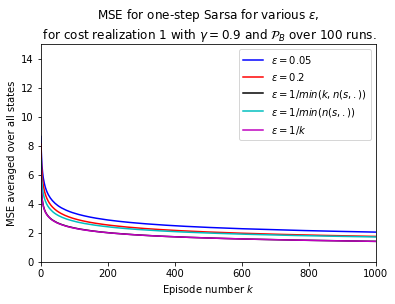

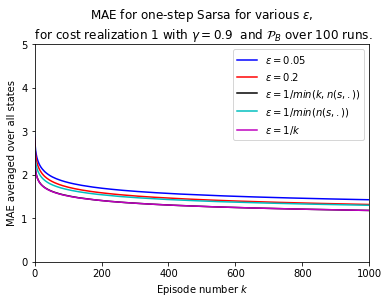

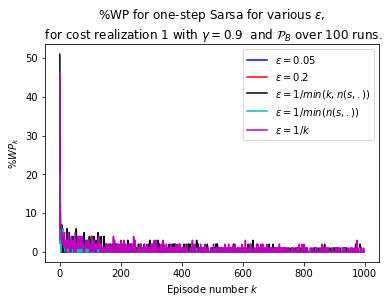

In [5]:

fig0, ax0 = plt.subplots()


ax0.plot(np.arange(nrepisodes),MSE_sarsa_0,'b-',label='$\epsilon=0.05$')

ax0.plot(np.arange(nrepisodes),MSE_sarsa_1,'r-',label='$\epsilon=0.2$')

ax0.plot(np.arange(nrepisodes),MSE_sarsa_2,'k-',label='$\epsilon=1/min(k,n(s,.))$')

ax0.plot(np.arange(nrepisodes),MSE_sarsa_3,'c-',label='$\epsilon=1/min(n(s,.))$')

ax0.plot(np.arange(nrepisodes),MSE_sarsa_4,'m-',label='$\epsilon=1/k$')

ax0.set(xlim=(0, nrepisodes), ylim=(0,15))

plt.title(r'MSE for one-step Sarsa for various $\epsilon,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+' and $\mathcal{P}_B$ over 100 runs.')
plt.xlabel('Episode number $k$')
plt.ylabel('MSE averaged over all states')
plt.legend() 


fig1, ax1 = plt.subplots()

ax1.plot(np.arange(nrepisodes),MAE_sarsa_0,'b-',label='$\epsilon=0.05$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_1,'r-',label='$\epsilon=0.2$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_2,'k-',label='$\epsilon=1/min(k,n(s,.))$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_3,'c-',label='$\epsilon=1/min(n(s,.))$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_4,'m-',label='$\epsilon=1/k$')

ax1.set(xlim=(0, nrepisodes), ylim=(0,5))

plt.title(r'MAE for one-step Sarsa for various $\epsilon,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+'  and $\mathcal{P}_B$ over 100 runs.')

plt.xlabel('Episode number $k$')
plt.ylabel('MAE averaged over all states')
plt.legend() 




fig2, ax2 = plt.subplots()


ax2.plot(np.arange(nrepisodes),100*policy_perc_eps0,'b-',label='$\epsilon=0.05$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps1,'r-',label='$\epsilon=0.2$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps2,'k-',label='$\epsilon=1/min(k,n(s,.))$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps3,'c-',label='$\epsilon=1/min(n(s,.))$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps4,'m-',label='$\epsilon=1/k$')


plt.title(r'%WP for one-step Sarsa for various $\epsilon,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+'  and $\mathcal{P}_B$ over 100 runs.')

plt.xlabel('Episode number $k$')
plt.ylabel('%$WP_k$')
plt.legend() 



Next, the MSE, MAE, and %WP for different $n$ in the $n$-step Sarsa algorithm will be computed and plotted for $n=\{1,2,3,4,5\}$. Here, we use $\alpha_t(s,a)=\frac{1}{n_t(s,a)}$ and $\epsilon_t=\frac{1}{\min\{k,n_t(s,0),n_t(s,1)\}}$.

In [6]:

# epsilon in epsilon-greedy:
     # in case we want to use one of the three epsilon depending
     # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
     # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
     # epsilon_type = 4: epsilon = 1/(episode nr) 
epsilon = 2

# discount factor
gamma=0.5

# number of states - 1
N=3

# nr of episodes
nrepisodes = 1000


# step-size alpha:
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
alpha=20

# transition matrix
# P_B
P = np.diag(1/2*np.ones(N),1)+np.diag(1/2*np.ones(N),-1)
P[-1,-2]=1
P[0,1]=1

# Realization 1
# Cost for action = 0
C_0=np.zeros(N+1)

# Cost for action = 1
C_1=np.arange(N+1,dtype=float)
C_1[N]=2*N

    
nrruns=100

# Putting the cost for "illegal actions" to infinity
C_0[N]=float("inf")
C_1[0]=float("inf")


# Initializing the value function
V=np.zeros(N+1)

# Initializing the policy
pi_s = np.ones(N+1,dtype=int)
pi_s[0]=0

# Number of iterations counter
it=0
while True:
    # Policy evaluation for policy pi_s
    V=Policy_Evaluation_2_actions(gamma,P,C_0,C_1,pi_s)
    
    # Policy improvement of policy pi_s
    policy = Policy_Improvement_2_actions(gamma,P,C_0,C_1,pi_s,V)
    
    # Incrementing the number of iterations by 1
    it+=1
    
    # Checking if the policy has changed
    if all(pi_s==policy):
        break
    
    # Assigning the improved policy to pi_s
    pi_s=policy.copy()


opt_policy = policy.copy()



MSE_sarsa_0_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_1_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_2_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_3_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_4_it = np.zeros([nrruns,nrepisodes])


MAE_sarsa_0_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_1_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_2_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_3_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_4_it = np.zeros([nrruns,nrepisodes])

policy_count_eps0 = np.zeros([nrruns,nrepisodes])
policy_count_eps1 = np.zeros([nrruns,nrepisodes])
policy_count_eps2 = np.zeros([nrruns,nrepisodes])
policy_count_eps3 = np.zeros([nrruns,nrepisodes])
policy_count_eps4 = np.zeros([nrruns,nrepisodes])

for i in range(0,nrruns):

    n=1
    Q, T, it, Q_it, n_it, a_it, s_it, r_it, G_it, alpha_it, policy, Q_ep_n1, policy_it_n1 = n_step_SARSA(n,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)

    n=2
    Q, T, it, Q_it, n_it, a_it, s_it, r_it, G_it, alpha_it, policy, Q_ep_n2, policy_it_n2 = n_step_SARSA(n,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)

    n=3
    Q, T, it, Q_it, n_it, a_it, s_it, r_it, G_it, alpha_it, policy, Q_ep_n3, policy_it_n3 = n_step_SARSA(n,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)

    n=4
    Q, T, it, Q_it, n_it, a_it, s_it, r_it, G_it, alpha_it, policy, Q_ep_n4, policy_it_n4 = n_step_SARSA(n,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)

    n=5
    Q, T, it, Q_it, n_it, a_it, s_it, r_it, G_it, alpha_it, policy, Q_ep_n5, policy_it_n5 = n_step_SARSA(n,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)


    #1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
    MSE_sarsa_0_it[i,:] = np.mean(np.array([(Q_ep_n1[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_1_it[i,:] = np.mean(np.array([(Q_ep_n2[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_2_it[i,:] = np.mean(np.array([(Q_ep_n3[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_3_it[i,:] = np.mean(np.array([(Q_ep_n4[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_4_it[i,:] = np.mean(np.array([(Q_ep_n5[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    
    # 1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
    MAE_sarsa_0_it[i,:] = np.mean(np.array([abs(Q_ep_n1[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_1_it[i,:] = np.mean(np.array([abs(Q_ep_n2[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_2_it[i,:] = np.mean(np.array([abs(Q_ep_n3[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_3_it[i,:] = np.mean(np.array([abs(Q_ep_n4[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_4_it[i,:] = np.mean(np.array([abs(Q_ep_n5[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    
    
    
    
    ## checking if the policy at run i is wrong (=1) for all episodes in the run
    policy_count_eps0[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it_n1).sum(axis=0) != 0).astype(int)
    policy_count_eps1[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it_n2).sum(axis=0) != 0).astype(int)
    policy_count_eps2[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it_n3).sum(axis=0) != 0).astype(int)
    policy_count_eps3[i,:] =  (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it_n4).sum(axis=0) != 0).astype(int)
    policy_count_eps4[i,:] =  (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it_n5).sum(axis=0) != 0).astype(int)
 

# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
MSE_sarsa_0 = np.mean(MSE_sarsa_0_it, axis=0)
MSE_sarsa_1 = np.mean(MSE_sarsa_1_it, axis=0)
MSE_sarsa_2 = np.mean(MSE_sarsa_2_it, axis=0)
MSE_sarsa_3 = np.mean(MSE_sarsa_3_it, axis=0)
MSE_sarsa_4 = np.mean(MSE_sarsa_4_it, axis=0)

# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
MAE_sarsa_0 = np.mean(MAE_sarsa_0_it, axis=0)
MAE_sarsa_1 = np.mean(MAE_sarsa_1_it, axis=0)
MAE_sarsa_2 = np.mean(MAE_sarsa_2_it, axis=0)
MAE_sarsa_3 = np.mean(MAE_sarsa_3_it, axis=0)
MAE_sarsa_4 = np.mean(MAE_sarsa_4_it, axis=0)


policy_perc_eps0 = np.mean(policy_count_eps0, axis=0)
policy_perc_eps1 = np.mean(policy_count_eps1, axis=0)
policy_perc_eps2 = np.mean(policy_count_eps2, axis=0)
policy_perc_eps3 = np.mean(policy_count_eps3,axis=0)
policy_perc_eps4 = np.mean(policy_count_eps4,axis=0)


Creating the plots:

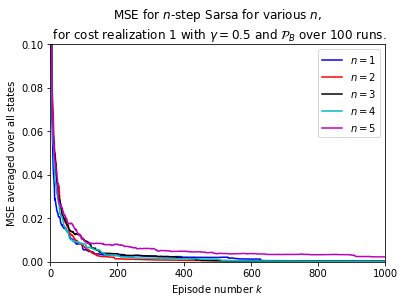

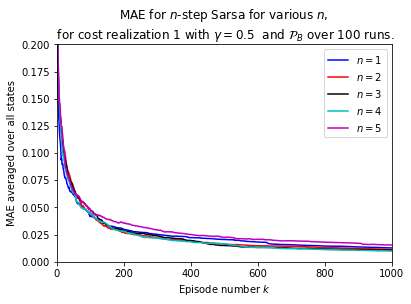

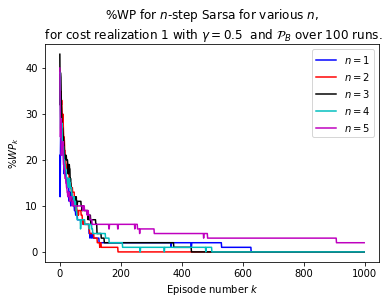

In [10]:
fig0, ax0 = plt.subplots()


ax0.plot(np.arange(nrepisodes),MSE_sarsa_0,'b-',label='$n=1$')

ax0.plot(np.arange(nrepisodes),MSE_sarsa_1,'r-',label='$n=2$')

ax0.plot(np.arange(nrepisodes),MSE_sarsa_2,'k-',label='$n=3$')

ax0.plot(np.arange(nrepisodes),MSE_sarsa_3,'c-',label='$n=4$')

ax0.plot(np.arange(nrepisodes),MSE_sarsa_4,'m-',label='$n=5$')

ax0.set(xlim=(0, nrepisodes), ylim=(0,0.1))

plt.title(r'MSE for $n$-step Sarsa for various $n,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+' and $\mathcal{P}_B$ over 100 runs.')
plt.xlabel('Episode number $k$')
plt.ylabel('MSE averaged over all states')
plt.legend() 




fig1, ax1 = plt.subplots()

ax1.plot(np.arange(nrepisodes),MAE_sarsa_0,'b-',label='$n=1$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_1,'r-',label='$n=2$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_2,'k-',label='$n=3$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_3,'c-',label='$n=4$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_4,'m-',label='$n=5$')

ax1.set(xlim=(0, nrepisodes), ylim=(0,0.2))

plt.title(r'MAE for $n$-step Sarsa for various $n,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+'  and $\mathcal{P}_B$ over 100 runs.')

plt.xlabel('Episode number $k$')
plt.ylabel('MAE averaged over all states')
plt.legend() 




fig2, ax2 = plt.subplots()


ax2.plot(np.arange(nrepisodes),100*policy_perc_eps0,'b-',label='$n=1$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps1,'r-',label='$n=2$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps2,'k-',label='$n=3$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps3,'c-',label='$n=4$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps4,'m-',label='$n=5$')



plt.title(r'%WP for $n$-step Sarsa for various $n,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+'  and $\mathcal{P}_B$ over 100 runs.')

plt.xlabel('Episode number $k$')
plt.ylabel('%$WP_k$')
plt.legend() 


Finally, the MSE, MAE, and %WP will be computed and plotted for the Sarsa$(\lambda)$ algortihm for $\lambda=\{0,0.25,0.5,0.75,1\}$. Here, we use $\alpha_t(s,a)=\frac{1}{n_t(s,a)}$ and $\epsilon_t=\frac{1}{\min\{k,n_t(s,0),n_t(s,1)\}}$.

In [11]:
# epsilon in epsilon-greedy:
     # in case we want to use one of the three epsilon depending
     # epsilon_type = 2: epsilon = 1/min(episode nr, minimum nr of visits to state s)
     # epsilon_type = 3: epsilon = 1/(minimum nr of visits to state s)
     # epsilon_type = 4: epsilon = 1/(episode nr) 
epsilon = 2


# discount factor
gamma=0.5

# number of states - 1
N=3

# nr of episodes
nrepisodes = 500


# step-size alpha:
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
alpha=20

# transition matrix
# P_B
P = np.diag(1/2*np.ones(N),1)+np.diag(1/2*np.ones(N),-1)
P[-1,-2]=1
P[0,1]=1

# Realization 1
# Cost for action = 0
C_0=np.zeros(N+1)

# Cost for action = 1
C_1=np.arange(N+1,dtype=float)
C_1[N]=2*N


nrruns=100

# Putting the cost for "illegal actions" to infinity
C_0[N]=float("inf")
C_1[0]=float("inf")


# Initializing the value function
V=np.zeros(N+1)

# Initializing the policy
pi_s = np.ones(N+1,dtype=int)
pi_s[0]=0

# Number of iterations counter
it=0
while True:
    # Policy evaluation for policy pi_s
    V=Policy_Evaluation_2_actions(gamma,P,C_0,C_1,pi_s)
    
    # Policy improvement of policy pi_s
    policy = Policy_Improvement_2_actions(gamma,P,C_0,C_1,pi_s,V)
    
    # Incrementing the number of iterations by 1
    it+=1
    
    # Checking if the policy has changed
    if all(pi_s==policy):
        break
    
    # Assigning the improved policy to pi_s
    pi_s=policy.copy()


opt_policy = policy.copy()



MSE_sarsa_0_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_1_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_2_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_3_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_4_it = np.zeros([nrruns,nrepisodes])


MAE_sarsa_0_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_1_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_2_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_3_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_4_it = np.zeros([nrruns,nrepisodes])

policy_count_eps0 = np.zeros([nrruns,nrepisodes])
policy_count_eps1 = np.zeros([nrruns,nrepisodes])
policy_count_eps2 = np.zeros([nrruns,nrepisodes])
policy_count_eps3 = np.zeros([nrruns,nrepisodes])
policy_count_eps4 = np.zeros([nrruns,nrepisodes])

for i in range(0,nrruns):

    lam=0
    Q, it, T, Q_it, states, actions, rewards, G, G_lambda, policy, policy_it_n1, Q_ep_n1 = SARSA_lambda(lam,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)

    lam=0.25
    Q, it, T, Q_it, states, actions, rewards, G, G_lambda, policy, policy_it_n2, Q_ep_n2 = SARSA_lambda(lam,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)

    lam=0.5
    Q, it, T, Q_it, states, actions, rewards, G, G_lambda, policy, policy_it_n3, Q_ep_n3 = SARSA_lambda(lam,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)

    lam=0.75
    Q, it, T, Q_it, states, actions, rewards, G, G_lambda, policy, policy_it_n4, Q_ep_n4 = SARSA_lambda(lam,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)

    lam=1
    Q, it, T, Q_it, states, actions, rewards, G, G_lambda, policy, policy_it_n5, Q_ep_n5 = SARSA_lambda(lam,alpha, gamma, epsilon,P,C_0,C_1, nrepisodes)


    #1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
    MSE_sarsa_0_it[i,:] = np.mean(np.array([(Q_ep_n1[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_1_it[i,:] = np.mean(np.array([(Q_ep_n2[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_2_it[i,:] = np.mean(np.array([(Q_ep_n3[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_3_it[i,:] = np.mean(np.array([(Q_ep_n4[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_4_it[i,:] = np.mean(np.array([(Q_ep_n5[j,opt_policy[j],:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    
    # 1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
    MAE_sarsa_0_it[i,:] = np.mean(np.array([abs(Q_ep_n1[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_1_it[i,:] = np.mean(np.array([abs(Q_ep_n2[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_2_it[i,:] = np.mean(np.array([abs(Q_ep_n3[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_3_it[i,:] = np.mean(np.array([abs(Q_ep_n4[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_4_it[i,:] = np.mean(np.array([abs(Q_ep_n5[j,opt_policy[j],:]-V[j]) for j in range(0,N+1)]),axis=0)
    
    
    
    
    ## checking if the policy at run i is wrong (=1) for all episodes in the run
    policy_count_eps0[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it_n1).sum(axis=0) != 0).astype(int)
    policy_count_eps1[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it_n2).sum(axis=0) != 0).astype(int)
    policy_count_eps2[i,:] = (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it_n3).sum(axis=0) != 0).astype(int)
    policy_count_eps3[i,:] =  (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it_n4).sum(axis=0) != 0).astype(int)
    policy_count_eps4[i,:] =  (abs(np.transpose(np.tile(opt_policy, (nrepisodes,1)))-policy_it_n5).sum(axis=0) != 0).astype(int)
 

# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
MSE_sarsa_0 = np.mean(MSE_sarsa_0_it, axis=0)
MSE_sarsa_1 = np.mean(MSE_sarsa_1_it, axis=0)
MSE_sarsa_2 = np.mean(MSE_sarsa_2_it, axis=0)
MSE_sarsa_3 = np.mean(MSE_sarsa_3_it, axis=0)
MSE_sarsa_4 = np.mean(MSE_sarsa_4_it, axis=0)

# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
MAE_sarsa_0 = np.mean(MAE_sarsa_0_it, axis=0)
MAE_sarsa_1 = np.mean(MAE_sarsa_1_it, axis=0)
MAE_sarsa_2 = np.mean(MAE_sarsa_2_it, axis=0)
MAE_sarsa_3 = np.mean(MAE_sarsa_3_it, axis=0)
MAE_sarsa_4 = np.mean(MAE_sarsa_4_it, axis=0)


policy_perc_eps0 = np.mean(policy_count_eps0, axis=0)
policy_perc_eps1 = np.mean(policy_count_eps1, axis=0)
policy_perc_eps2 = np.mean(policy_count_eps2, axis=0)
policy_perc_eps3 = np.mean(policy_count_eps3,axis=0)
policy_perc_eps4 = np.mean(policy_count_eps4,axis=0)


Creating the plots:

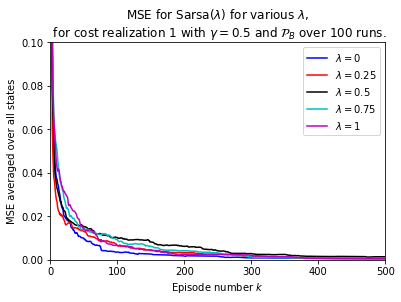

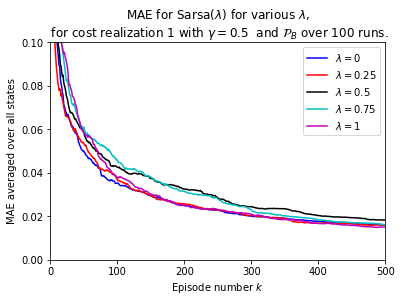

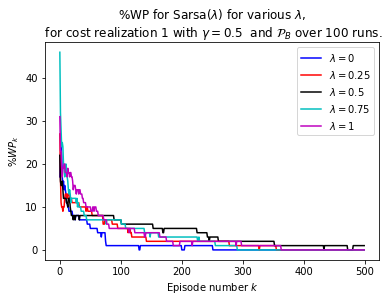

In [13]:

fig0, ax0 = plt.subplots()


ax0.plot(np.arange(nrepisodes),MSE_sarsa_0,'b-',label=r'$\lambda=0$')

ax0.plot(np.arange(nrepisodes),MSE_sarsa_1,'r-',label=r'$\lambda=0.25$')

ax0.plot(np.arange(nrepisodes),MSE_sarsa_2,'k-',label=r'$\lambda=0.5$')

ax0.plot(np.arange(nrepisodes),MSE_sarsa_3,'c-',label=r'$\lambda=0.75$')

ax0.plot(np.arange(nrepisodes),MSE_sarsa_4,'m-',label=r'$\lambda=1$')

ax0.set(xlim=(0, nrepisodes), ylim=(0,0.1))

plt.title(r'MSE for Sarsa$(\lambda)$ for various $\lambda,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+' and $\mathcal{P}_B$ over 100 runs.')
plt.xlabel('Episode number $k$')
plt.ylabel('MSE averaged over all states')
plt.legend() 




fig1, ax1 = plt.subplots()

ax1.plot(np.arange(nrepisodes),MAE_sarsa_0,'b-',label=r'$\lambda=0$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_1,'r-',label=r'$\lambda=0.25$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_2,'k-',label=r'$\lambda=0.5$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_3,'c-',label=r'$\lambda=0.75$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_4,'m-',label=r'$\lambda=1$')

ax1.set(xlim=(0, nrepisodes), ylim=(0,0.1))

plt.title(r'MAE for Sarsa$(\lambda)$ for various $\lambda,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+'  and $\mathcal{P}_B$ over 100 runs.')
plt.xlabel('Episode number $k$')
plt.ylabel('MAE averaged over all states')
plt.legend() 



fig2, ax2 = plt.subplots()


ax2.plot(np.arange(nrepisodes),100*policy_perc_eps0,'b-',label=r'$\lambda=0$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps1,'r-',label=r'$\lambda=0.25$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps2,'k-',label=r'$\lambda=0.5$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps3,'c-',label=r'$\lambda=0.75$')
ax2.plot(np.arange(nrepisodes),100*policy_perc_eps4,'m-',label=r'$\lambda=1$')

plt.title(r'%WP for Sarsa$(\lambda)$ for various $\lambda,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+'  and $\mathcal{P}_B$ over 100 runs.')

plt.xlabel('Episode number $k$')
plt.ylabel('%$WP_k$')
plt.legend() 
